## **Project: Sentiment Analysis on Amazon Product Reviews**




In [1]:
FIRST_NAME = "Muthu"
LAST_NAME = "Selvam"
STUDENT_ID = "801276057"

In [2]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re
from contractions import contractions_dict
from string import punctuation
import warnings
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Create Amazon Customer Reviews DataFrame from JSON objects

In [4]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Cell_Phones_and_Accessories_5.json.gz')

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]","Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [5]:
df = df.dropna(subset = ['reviewText','summary'])
df.isna().sum()

reviewerID        0   
asin              0   
reviewerName      3519
helpful           0   
reviewText        0   
overall           0   
summary           0   
unixReviewTime    0   
reviewTime        0   
dtype: int64

In [6]:
print(df['overall'].value_counts())
df['overall'].value_counts(normalize=True) * 100

5.0    108664
4.0    39993 
3.0    21439 
1.0    13279 
2.0    11064 
Name: overall, dtype: int64


5.0    55.885908
4.0    20.568404
3.0    11.026080
1.0    6.829391 
2.0    5.690216 
Name: overall, dtype: float64

## Separate positive and negative reviews for analysis

In [7]:
df_negative_reviews = df[df['overall']<3].iloc[:100000]
df_positive_reviews = df[df['overall']>3].iloc[:200000]

In [8]:
df_new = df.iloc[:100]
df_new.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]","Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


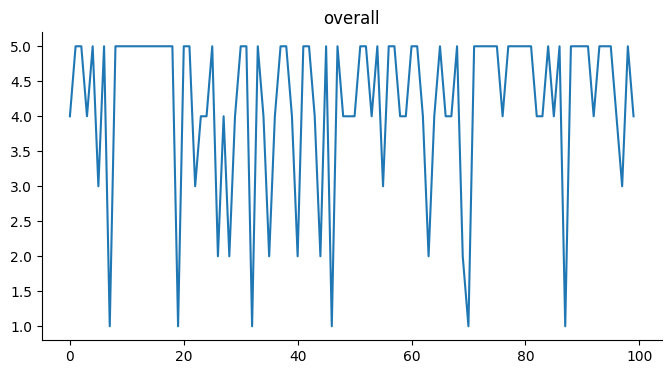

In [11]:
# @title overall

from matplotlib import pyplot as plt
df_new['overall'].plot(kind='line', figsize=(8, 4), title='overall')
plt.gca().spines[['top', 'right']].set_visible(False)

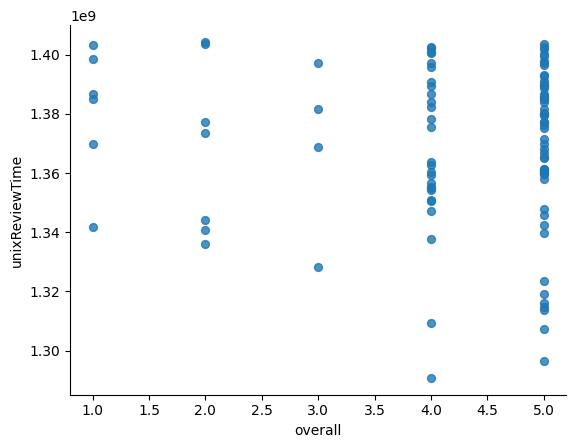

In [12]:
# @title overall vs unixReviewTime

from matplotlib import pyplot as plt
df_new.plot(kind='scatter', x='overall', y='unixReviewTime', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Review Text PreProcssing Function Definitions

In [13]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text



def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [16]:
from nltk.tokenize import RegexpTokenizer
def cleanme(txt):
    sent = txt.lower()
    sent_expanded_contractions = expand_contractions(sent,contractions_dict)
    sent_expanded_contractions = re.sub(r'(?<=[.,])(?=[^\s])', r' ', sent_expanded_contractions)
    sent_without_punct = strip_punctuation(sent_expanded_contractions)
    sent_without_digits=re.sub('[0-9]+', '', sent_without_punct)

    TOKENIZER = RegexpTokenizer('(?u)\W+|\$[\d\.]+|\S+')
    wrds = word_tokenize(sent_without_digits)
    to_remove = ['no', 'not']
    new_stopwords = set(stopwords.words('english')).difference(to_remove)
    clwrds = [w for w in wrds if not w in new_stopwords]
    ln = len(clwrds)
    if ln>0:
        pos = pd.DataFrame(pos_tag(wrds))
        pos = (" ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))).split(" ")
        l2 = ["i","you","me"]
        pos = [x for x in pos if x not in l2]
    else:
        pos = [""]
    rt = [ln, " ".join(clwrds), " ".join(pos)]
    return(rt)